In [1]:
%load_ext autoreload
%autoreload 2

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [2]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 5000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 1.0, 'contrast': 1.0, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 26, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 500, 'dim2': 2000, 'lr': 0.001, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.2, 'momentum': 0.1, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-27', 'seed': 2019, 'N_cv': 8, 'do_compute': True}
Overwriting train.py
2020-01-23T14:57:18+01:00

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
matplotlib 

In [3]:
figname = '../figures/fig_intro'

# A/ process generating display images

In [4]:
from display import Display
d = Display(args)
data, label = next(iter(d.loader_test))

In [5]:
print('data.shape=', data.shape)

data.shape= torch.Size([5000, 1, 28, 28])


## loading the MNIST dataset

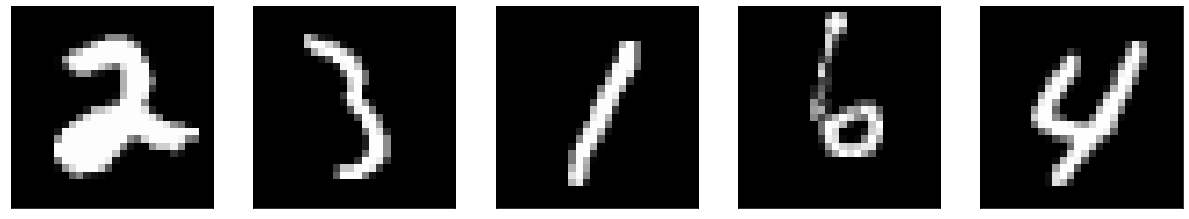

In [6]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for i_ax, ax in enumerate(axs):
    ax.imshow(data[i_ax, 0, :, :], cmap=plt.gray())
    ax.set_xticks([])
    ax.set_yticks([])

## placing the digits in some random noise

In [7]:
from display import minmax, place_object

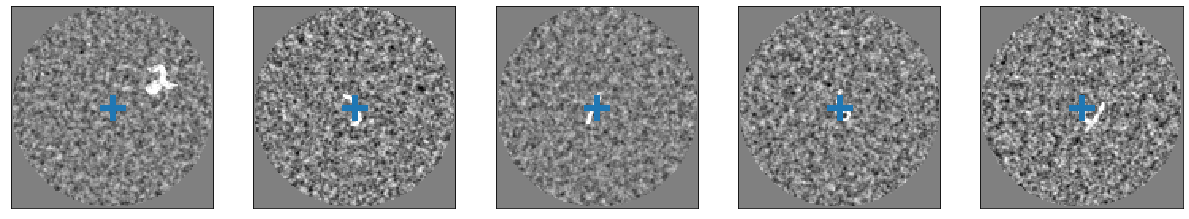

In [8]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 8))
for i_ax, ax in enumerate(axs):
    data_fullfield, i_offset, j_offset = d.draw(data[i_ax, 0, :, :].numpy())
    ax = d.show(ax, data_fullfield)


In [9]:
idx = 4
i_offset, j_offset = -29, 21

In [10]:
#data_fullfield, i_offset, j_offset = d.draw(data[0, 0, :, :].numpy())
data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), i_offset, j_offset)

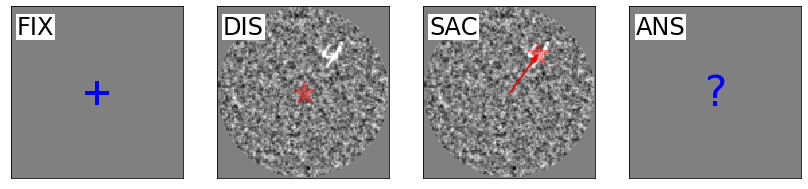

In [11]:
texts = ['FIX', 'DIS', 'SAC', 'ANS']
def panel_A(fig=None, axs=None):

    N_plot = 4

    if fig is None:
        fig, axs = plt.subplots(1, N_plot, figsize = (figwidth, figwidth/4))
    for ax, text in zip(axs, texts):
        ax.imshow(.5 + np.zeros_like(data_fullfield), cmap=plt.gray(), vmin=0, vmax=1)
        if text=='FIX': 
            ax.plot([args.N_pic//2], [args.N_pic//2], '+', color='b', ms=24, markeredgewidth=4)
        elif text in ['DIS', 'SAC']: 
            ax.imshow(data_fullfield, cmap=plt.gray(), vmin=0, vmax=1)
            opts = dict(ms=24, markeredgewidth=1, alpha=.4)
            if text == 'DIS':
                ax.plot([args.N_pic//2], [args.N_pic//2], '*r', **opts)
            else:
                ax.plot([args.N_pic//2+j_offset], [args.N_pic//2+i_offset], '*r', **opts)
                ax.arrow(args.N_pic//2, args.N_pic//2, j_offset, i_offset, width=.3, color='r', 
                         head_width=4., length_includes_head=True, edgecolor='k')
        elif text=='ANS':         
            ax.text(args.N_pic//2, args.N_pic//2, '?', color='b', fontsize=42,
              ha='center', va='center')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(4, 15, text, fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center') 

    # TODO: show arrow of time
    #fig.arrow(N_pic//2, N_pic//2, j_offset - 4 * N_pic, i_offset, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
    return fig, axs
fig_A, axs_A = panel_A()
#fig_A.savefig(figname + '.pdf')

# B/ a sample saccade

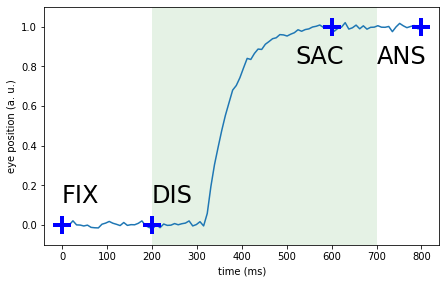

In [12]:
def panel_B(fig=None, axs=None, N_time=100, offset=.15, fontsize=24, ms=18, markeredgewidth=4, alpha=.1):
    if fig is None:
        fig, axs = plt.subplots(1, 1, figsize=(figwidth/2, figwidth/phi/2))
    
    time = np.linspace(0, 800, N_time)
    latency = 320
    EM = 1. - np.exp(- (time-latency) / 54. ) 

    EM[time<latency] = 0
    EM += .01 * np.random.randn(N_time)

    start, sac, end = 200, 600, 700
    axs.plot(time, EM)
    axs.plot([start], [0], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    axs.plot([sac], [1], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    axs.plot([0], [0], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    axs.plot([800], [1], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    opts = dict(fontsize=fontsize,
          bbox={'facecolor':'white','alpha':0,'edgecolor':'none','pad':1},
          ha='left', va='center')
    axs.text(0, offset, 'FIX', **opts)
    axs.text(start, offset, 'DIS', **opts)
    axs.text(sac-80, 1-offset, 'SAC', **opts)
    axs.text(700, 1-offset, 'ANS', **opts)
    axs.fill_between([start, end], y1=1.15, y2=-.15, facecolor='g', alpha=alpha)
    axs.set_ylim([-.1, 1.1])
    axs.set_xlabel('time (ms)')
    axs.set_ylabel('eye position (a. u.)')
    return fig, axs

fig_B, axs_B = panel_B()

# C/ foveation

In [13]:
from retina import Retina
r = Retina(args)

In [14]:
idx = 4
i_offset, j_offset = -29, 21
data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), i_offset, j_offset)
data_fullfield_0 = d.place_object(data[idx, 0, :, :].numpy(), 0, 0)

data_retina = r.retina(data_fullfield)
data_retina_0   = r.retina(data_fullfield_0)

do_dewhitening = True
im_0 = r.retina_invert(data_retina_0, do_dewhitening=do_dewhitening)
im = r.retina_invert(data_retina, do_dewhitening=do_dewhitening)

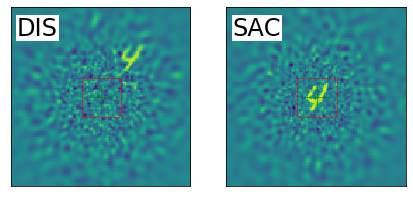

In [15]:
def panel_C(fig=None, axs=None,):
    N_pic = args.N_pic
    w = data[idx, 0, :, :].numpy().shape[0]
    rmin = min((im.min(), im_0.min()))
    rmax = max((im.max(), im_0.max()))
    if fig is None:
        fig, axs = plt.subplots(1, 2, figsize=(figwidth/2, figwidth/phi/2))
    for ax, text in zip(axs, texts[1:3]):
        if text == 'DIS':
            ax = r.show(ax, im, rmin=rmin, rmax=rmax)
        else:
            ax = r.show(ax, im_0, rmin=rmin, rmax=rmax)

        ax.text(4, 15, text, fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center') 

    return fig, axs
fig_C, axs_C = panel_C()
# fig_B.savefig(figname + '.pdf')

# summary

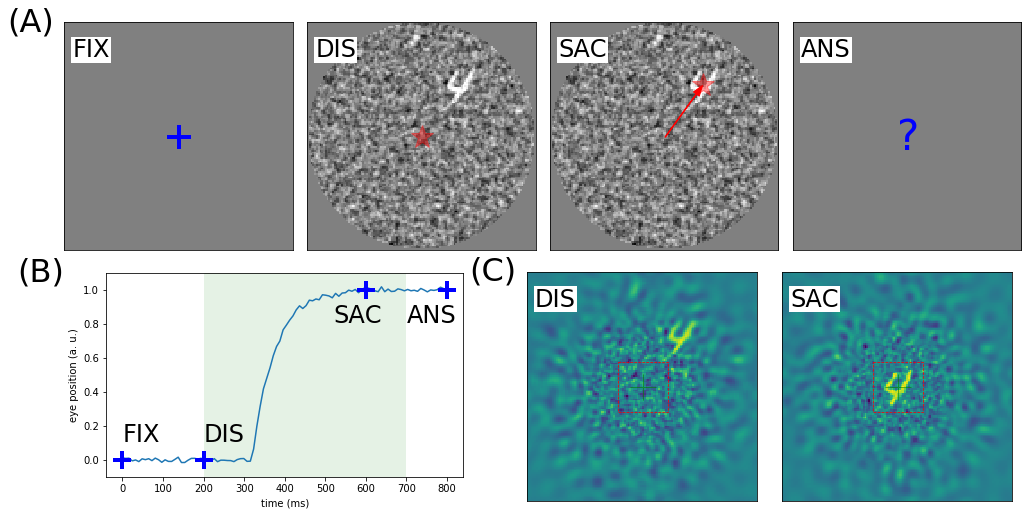

In [16]:
# fig = plt.figure(figsize = (21, 13))
fig, axs = plt.subplots(2, 4, figsize = (figwidth, figwidth/2), constrained_layout=True)
    
fig, axs_A = panel_A(fig=fig, axs=axs[0])
fig, axs_B = panel_B(fig=fig, axs=axs[1][0])
fig, axs_C = panel_C(fig=fig, axs=axs[1][1:3])
axs[1][3].remove()
# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.
axs_B.set_position([0.1, 0.0725, .35, 0.4])
axs_C[0].set_position([0.4, .025, .45, .45])
axs_C[1].set_position([0.65, .025, .45, .45])
offset = -.25
for ax, text, x, y in [[axs_A[0], 'A', offset, 1], [axs_B, 'B', offset, 1], [axs_C[0], 'C', offset, 1]]:
    ax.text(x, y, '(' + text + ')', fontsize=32,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

#plt.tight_layout()
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [17]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

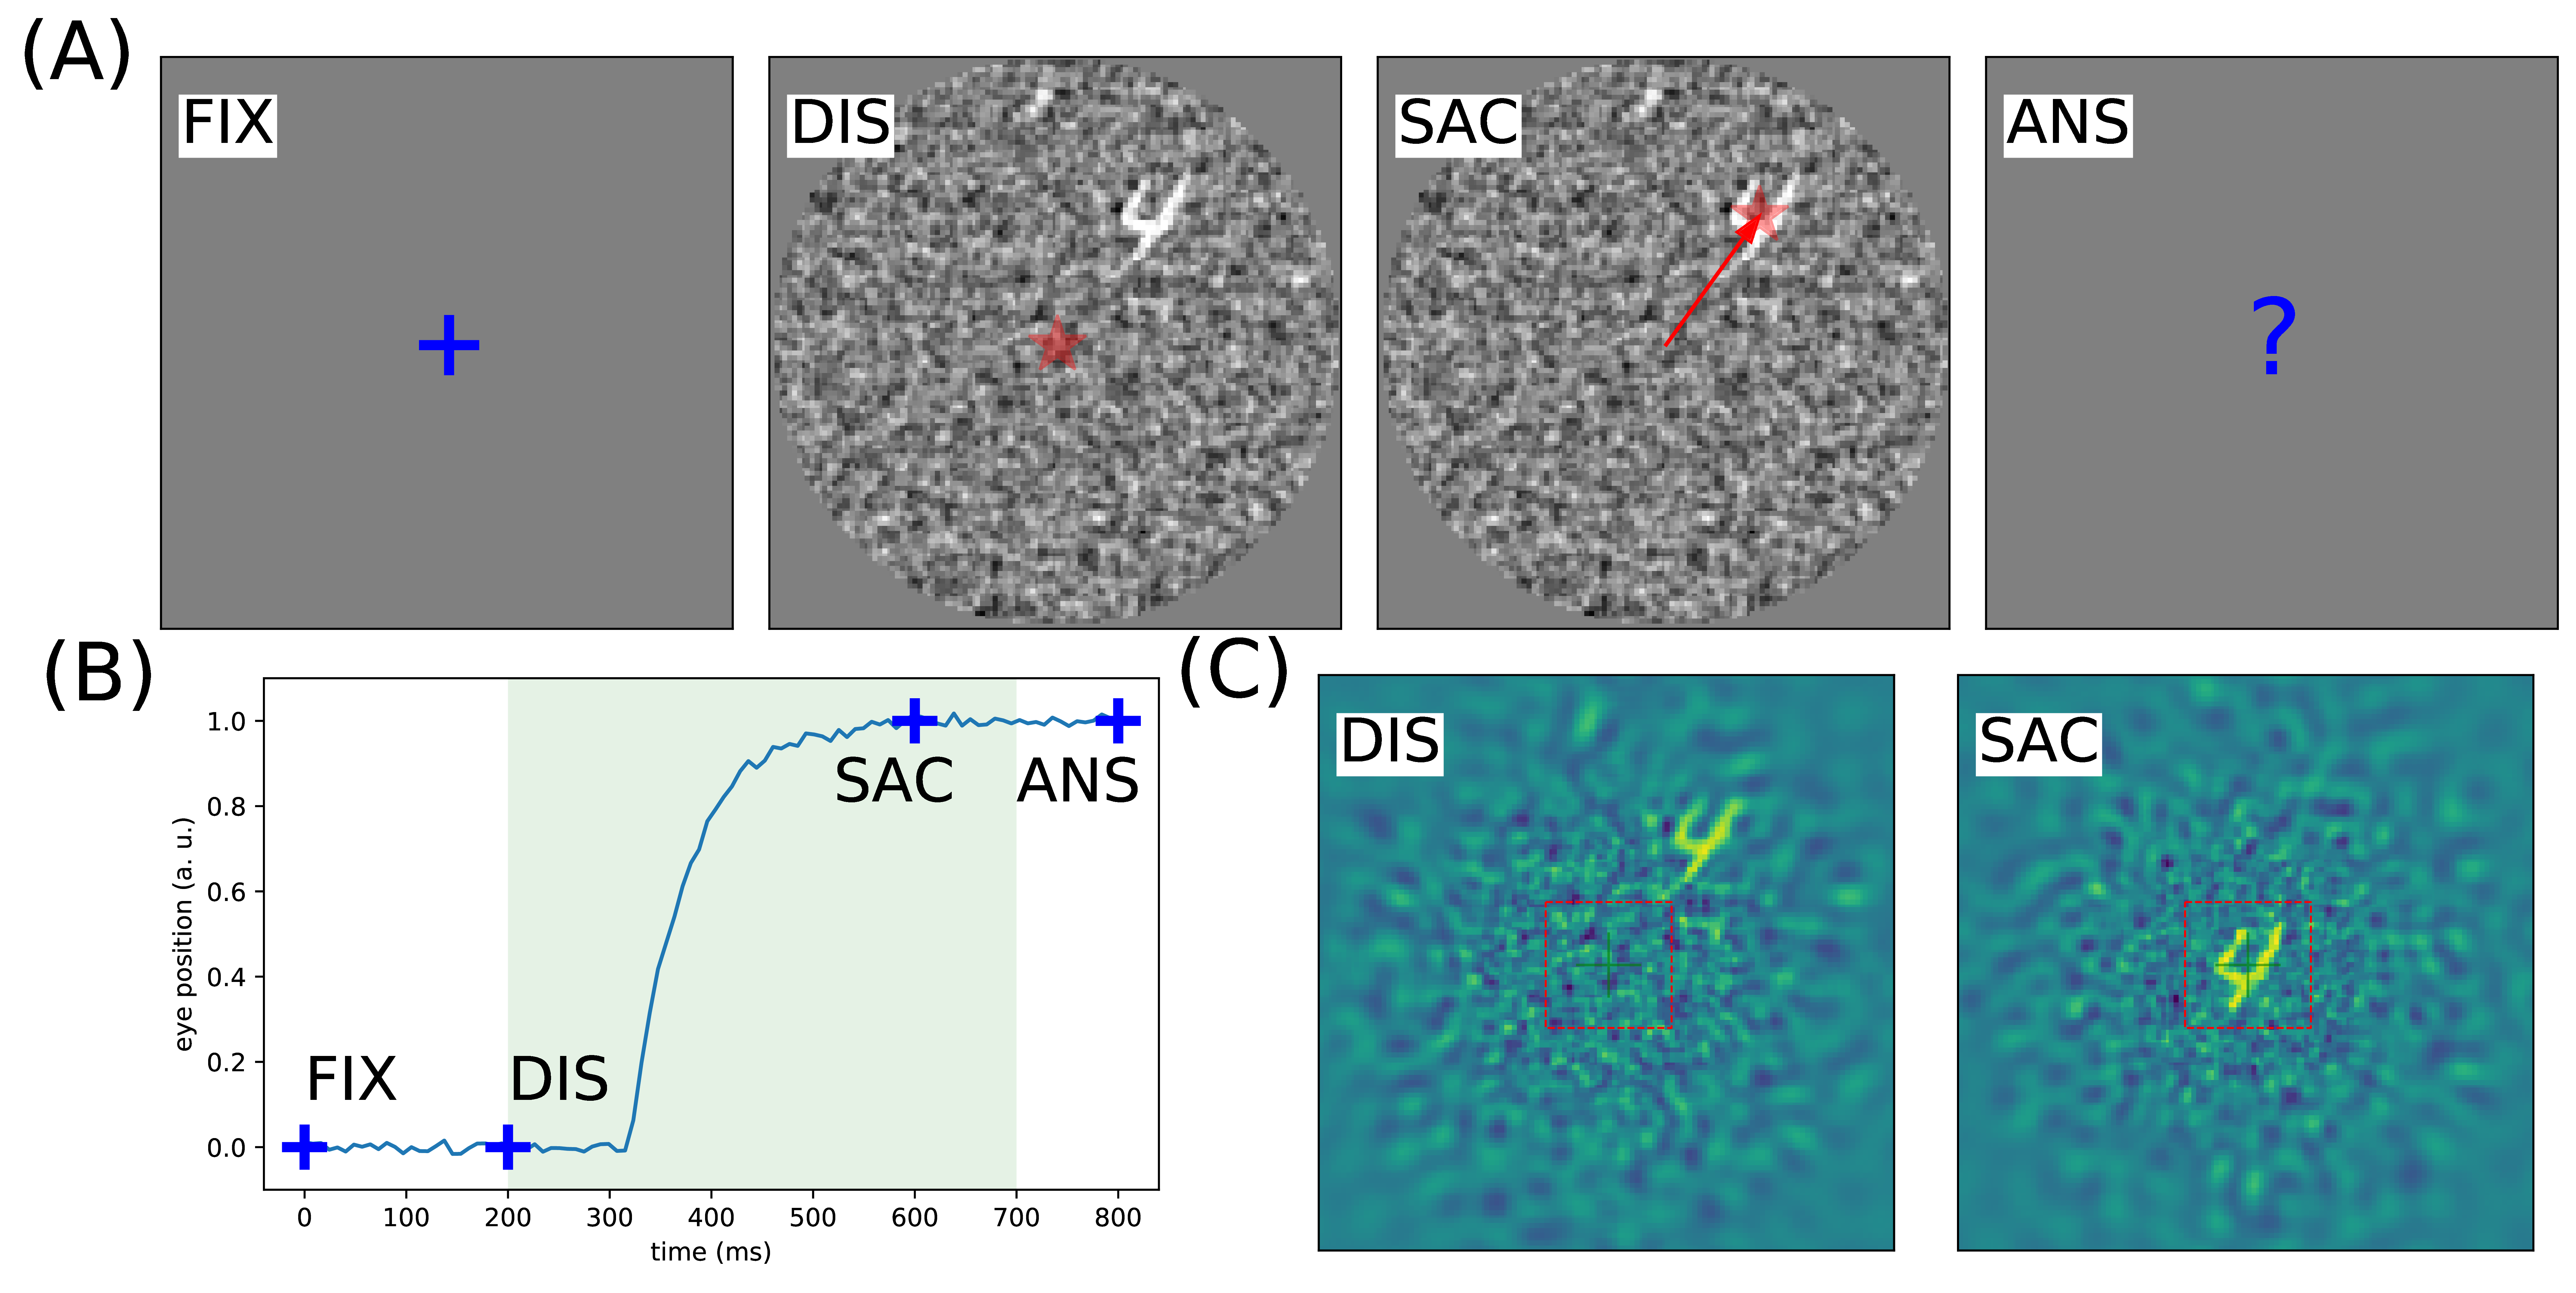

In [18]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [19]:
!ls  -l {figname}*

-rw-r--r--  1 laurentperrinet  staff  2630522 Jan 23 14:57 ../figures/fig_intro.jpg
-rw-r--r--  1 laurentperrinet  staff   131561 Jan 23 14:57 ../figures/fig_intro.pdf
-rw-r--r--  1 laurentperrinet  staff   491759 Jan 23 14:57 ../figures/fig_intro.png
